# Layer normalization

Podatocite se normaliziraat so cel da imaat prosek priblizen na 0 i varijansa 1.

In [ ]:
import torch
import torch.nn as nn

Izlez od sekvencijalen sloj so aktivacija reLU na nekoj random batch

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Znacenjeto na dim i keepdim: ako dim e -1 ili 1 presmetuva prosek na redici, a ako e 0 presmetuva na koloni. Ako keepdim e true go vrakja tensorot vo ista forma kako sto bil vnesen, dodeka so false moze da se smeni da bide vektor

Podatocite pred normalizacija:

In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
mean_pr = out.mean(dim=0, keepdim=False)
var_pr = out.var(dim=0, keepdim=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


Normalizacija na tensorite

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Primenuvanje na slojot za normalizacija kako klasa

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 #sprecuva delenje so 0
     #parametri koi ucat dodeka se trenira, so nivna promena se podobruva modelot.
    self.scale = nn.Parameter(torch.ones(emb_dim)) #inicijalno postaven na 1, so nego se mnozi i se menuva vrednosta vo zavisnost od modelot
    self.shift = nn.Parameter(torch.zeros(emb_dim)) #inicijalno 0, so nego se dodava i se menuva vrednosta ....
  def forward(self,x):
     mean = x.mean(dim=-1, keepdim=True) #prosek na tensorot
     var = x.var(dim=-1, keepdim=True, unbiased=False) #varijansa
     norm_x = (x - mean) / torch.sqrt(var + self.eps) #normalizacija so pomos na formula
     return self.scale * norm_x + self.shift #vklucuvanje na parametrite



so shift i scale parametrite se podobruva performansot na modelot. Na pocetokot tie nemaat nikakov efekt ama posle toa obezbeduvaat da nema golem loss.

In [ ]:
ln = LayerNormalization(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)


Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Feed forward so GELU aktivacija

Formulata na GELU:

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

GeLU vs ReLU

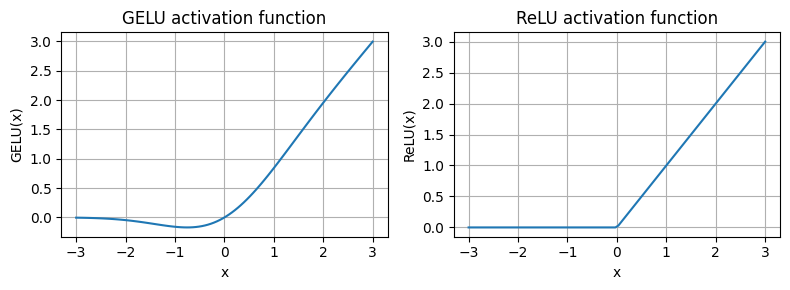

In [ ]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

GeLU ne e tolku ostar kako ReLu sto znaci deka polesno prifakja razlicni podatoci. Isto taka gi zema vo predvid negativnite vrednosti. ReLU avtomatski gi postavuva negativnite vrednosti na 0.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
cfg = {
    "emb_dim": 768
}

model = FeedForward(cfg)
x = torch.rand(2, 3, 768)
out = model(x)
print(out.shape)

torch.Size([2, 3, 768])


# Shortcut connectors

Se dodavaat za da se spreci problemot so namaluvanje na gradient.

*** gradient e vektor koj e izvod na loss funckijata. toj ni e pokazatel kolku treba da go podobrime modelot za da se namali loss funkcijata.

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            # Implement 5 layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork( #primer bez shortcut za da vidime kako se odnesuva gradientot
    layer_sizes, use_shortcut=False
)

In [ ]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_shortcut = ExampleDeepNeuralNetwork( #primer bez shortcut za da vidime kako se odnesuva gradientot
    layer_sizes, use_shortcut=True
)

In [ ]:
print_gradients(model_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# Transformer block

Gi sumira multi head attention, feed forward, dropout, layer normalization, GeLU, shortcut vo edna zaednicka klasa

Od prethodnata nedela MultiHeadAttention:

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec



In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,      # Context length
    "emb_dim": 768,       # Embedding dimension
    "n_heads": 12,        # Number of attention heads
    "n_layers": 12,       # Number of layers
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention( #specificiranje na parametrite za multiheadattention
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg) #povik na feedforward
        self.norm1 = LayerNormalization(cfg["emb_dim"]) #normalizacija pred self attention
        self.norm2 = LayerNormalization(cfg["emb_dim"]) #normalizacija pred feed forward
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"]) #dropout

    def forward(self, x):

        shortcut = x #zacuvuvanje na originalniot tensor x vo shortcut
        x = self.norm1(x) #normaliziranje na tensorot pred attention layer
        x = self.att(x) #attention layer
        x = self.drop_shortcut(x) #dropout layer
        x = x + shortcut  # dodavanje na originalniot tensor vo x za da se zacuva primarniot input

        shortcut = x  #povtorno zacuvuvanje na tensor pominat preku attention layer i shortcut
        x = self.norm2(x) #normalizacija pred feed forward
        x = self.ff(x) #feed forward
        x = self.drop_shortcut(x) #dropout layer
        x = x + shortcut #dodavanje na tensorot pominat preku att za da se zacuva primarnata informacija
        return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# GPT model

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) #tokenizacija
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #positional embedding
        self.drop_emb = nn.Dropout(cfg["drop_rate"]) #dropout

        self.trf_blocks = nn.Sequential( #sekvencijalno povikuvanje na transformeri spored brojor na layers
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNormalization(cfg["emb_dim"]) #posledna normalizacija pred izlez
        self.out_head = nn.Linear( #linearen izlez
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape #gi zem goleminata na batchot i sekvencta od dimenziite na tensorot
        tok_embeds = self.tok_emb(in_idx) #embeding na tokenot

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) #poziciski embeding
        x = tok_embeds + pos_embeds #tensor od positional embeding i tokenizacija sto go dava semantickoto znacenje
        x = self.drop_emb(x) #dropout
        x = self.trf_blocks(x) #povik na transformation blocks
        x = self.final_norm(x) #posledna normalizacija pred output
        logits = self.out_head(x) #output
        return logits

In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Ocekuvano e da ima 124 milioni parametri, no ima 163M. Ova e zatoa sto sto modelot na gpt2 ne koristi weight tying pravilno...???

In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


Sega otkako se upotrebi weight tying se podobri modelot

In [ ]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


# GPT model so tekst

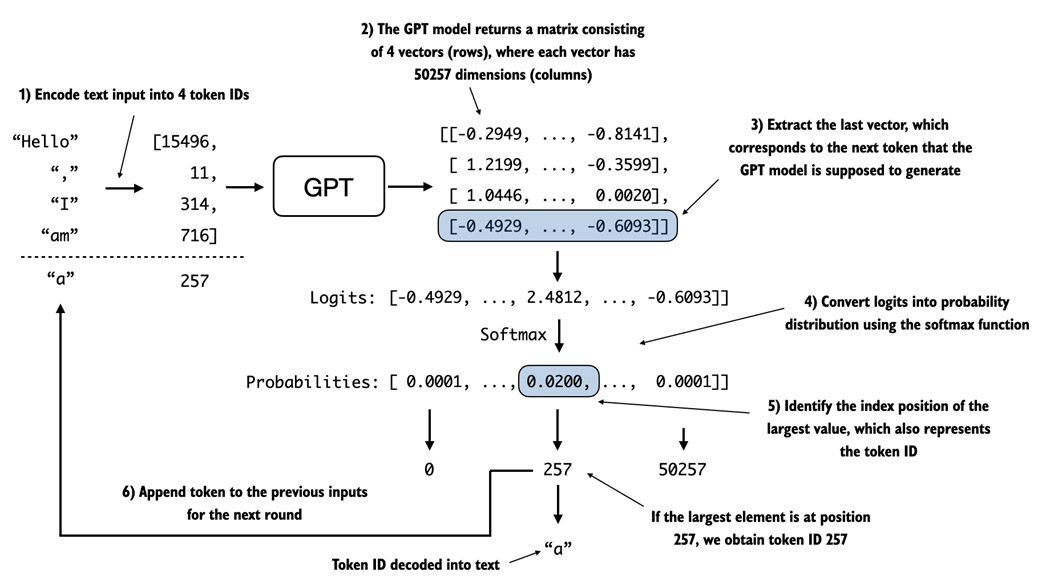

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens): #vrti za da generira onolku zborovi kolku sto se baraat
        idx_cond = idx[:, -context_size:] #go zema posledniot token od idx za da napravi predviduvanje so pomos na nego
        with torch.no_grad():
            logits = model(idx_cond) #se dobivaat logits za sledniot token

        logits = logits[:, -1, :] #od logits go zema posledniot za da go predivi sledniot zbor so negova pomos
        probas = torch.softmax(logits, dim=-1) #so softmax presmetuva verojatnosti na logitsot
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #koristi greedy bidejki go bira zborot so najgolema verojatnost
        idx = torch.cat((idx, idx_next), dim=1) #go konkatanira zborot so najgolema verojantost vo sekvencata od zborovi

    return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


Moj obid

In [ ]:
model=GPTModel(GPT_CONFIG_124M)
tokenizer=tiktoken.get_encoding("gpt2")

In [ ]:
recenica="I like playing"
embed_recenica=tokenizer.encode(recenica)
embed_recenica


[40, 588, 2712]

In [ ]:
embed_recenica=torch.tensor([embed_recenica]) #za da raboti vo torch mora da ja napravam vo tensor
embed_recenica

tensor([[  40,  588, 2712]])

In [ ]:
max_new_tokens = 4 #predviduva naredni 4 zbora
context_size = 3  # 3 zbora se dadeni kako input

In [ ]:
new_tokens = generate_text_simple(model, embed_recenica, max_new_tokens, context_size)

In [ ]:
print(f"New Tokens: {new_tokens}")

New Tokens: tensor([[   40,   588,  2712, 48087, 46771, 36276, 10679]])


In [ ]:
generated_text = tokenizer.decode(new_tokens[0].tolist())

print(f"Generated Text: {generated_text}")

Generated Text: I like playing Macintosh paperbackFindingennis


Nelogicen output?

# Zadaci

Exercise 4.1 Number of parameters in feed forward and attention modules

Calculate and compare the number of parameters that are contained in the feed forward module and those that are contained in the multi-head attention module.

In [ ]:
block = TransformerBlock(GPT_CONFIG_124M)
total_params = sum(p.numel() for p in block.ff.parameters())
print(f"Total number of parameters in feed forward module: {total_params:,}")

Total number of parameters in feed forward module: 4,722,432


In [ ]:
block = TransformerBlock(GPT_CONFIG_124M)
total_params = sum(p.numel() for p in block.att.parameters())
print(f"Total number of parameters in feed forward module: {total_params:,}")

Total number of parameters in feed forward module: 2,360,064


In this chapter, we initialized a 124 million parameter GPT model, which is known as "GPT-2 small." Without making any code modifications besides updating the configuration file, use the GPTModel class to implement GPT-2 medium (using 1024-dimensional embeddings, 24 transformer blocks, 16 multi-head attention heads), GPT-2 large (1280-dimensional embeddings, 36 transformer blocks, 20 multi-head attention heads), and GPT-2 XL (1600-dimensional embeddings, 48 transformer blocks, 25 multi-head attention heads). As a bonus, calculate the total number of parameters in each GPT model.

In [ ]:
GPT_2_SMALL = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,      # Context length
    "emb_dim": 1024,       # Embedding dimension
    "n_heads": 16,        # Number of attention heads
    "n_layers": 24,       # Number of layers
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

In [ ]:
model = GPTModel(GPT_2_SMALL)
total_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {total_params:,}")

Parameters: 406,212,608


In [ ]:
GPT_2_LARGE = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,      # Context length
    "emb_dim": 1280,       # Embedding dimension
    "n_heads": 20,        # Number of attention heads
    "n_layers": 36,       # Number of layers
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

In [ ]:
model = GPTModel(GPT_2_LARGE)
total_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {total_params:,}")

Parameters: 838,220,800


In [ ]:
GPT_2_XL = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,      # Context length
    "emb_dim": 1600,       # Embedding dimension
    "n_heads": 25,        # Number of attention heads
    "n_layers": 48,       # Number of layers
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

In [ ]:
model = GPTModel(GPT_2_XL)
total_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {total_params:,}")

Parameters: 1,637,792,000


Exercise 4.3 Using separate dropout parameters

At the beginning of this chapter, we defined a global "drop_rate" setting in the GPT_CONFIG_124M dictionary to set the dropout rate in various places throughout the GPTModel architecture. Change the code to specify a separate dropout value for the various dropout layers throughout the model architecture. (Hint: there are three distinct places where we used dropout layers: the embedding layer, shortcut layer, and multi-head attention module.)

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate_emb": 0.5,        # NEW: dropout for embedding layers
    "drop_rate_attn": 0.1,       # NEW: dropout for multi-head attention
    "drop_rate_shortcut": 0.6,   # NEW: dropout for shortcut connections
    "qkv_bias": False
}

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate_attn"], # TUKA
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["emb_dim"])
        self.norm2 = LayerNormalization(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate_shortcut"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate_emb"]) # TUKA

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNormalization(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)